# **CS210 Project**

# Hypothesis Formulation:
Start by clearly defining your hypothesis about how your music listening habits change during different periods of the day based on Spotify data. For example, "I hypothesize that my music preferences change through the hours of the day."

# **1. Data Collection**
Collect past Spotify data, such as genres, timestamps, and any other pertinent details like your age, location, or significant life events. Make sure the information you gather is appropriate for verifying your theory.

In [ ]:
# code here

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seaborn style and context for better visualization
sns.set_style('whitegrid')  # Choose 'white', 'dark', 'whitegrid', 'darkgrid', or 'ticks'
sns.set_context('notebook')

In [ ]:
# code here

import pandas as pd

# Since the JSON file is in the same folder as your Jupyter notebook, you can use the filename directly
json_file_path = 'StreamingHistory0.json'
streaming_data = pd.read_json(json_file_path)

# Reset the index to start from 1
streaming_data.index = range(1, len(streaming_data) + 1)

# Display the first few rows of the DataFrame
streaming_data.head()

,endTime,artistName,trackName,msPlayed
1,2022-12-04 22:33,Kupla,Paradise,46158
2,2022-12-05 05:45,Guitarricadelafuente,Agua y Mezcal,212558
3,2022-12-05 05:50,Alice Wonder,Bajo La Piel,301783
4,2022-12-05 05:55,Mako,Roller Coaster - Jan Blomqvist Remix,260280
5,2022-12-05 05:58,Metro Boomin,Around Me (feat. Don Toliver),191520


In [ ]:
!pip install pandas matplotlib seaborn spotipy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 4.6 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Set up your Spotify API credentials
client_id = '5928a81f11254f6cb2741406939fdcb3'
client_secret = '4975dce01c6d40ba89d688ea0774dca1'

# Authenticate with Spotify
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Test the connection (for example, search for a track)
results = sp.search(q='track:Wind Song artist:Ludovico Einaudi', type='track')
# Extract artist ID from the track information
artist_id = results['tracks']['items'][0]['artists'][0]['id']

# Fetch the artist's details using the artist ID
artist_details = sp.artist(artist_id)

# Print the genres associated with the artist
print("Genres:", artist_details['genres'])



Genres: ['compositional ambient', 'neo-classical']


In [ ]:
import pandas as pd
import json
import time

# Load your JSON data into a DataFrame
with open('StreamingHistory0.json', 'r') as file:
    data = json.load(file)

df = pd.DataFrame(data)

# Cache for storing genres of artists already looked up
genre_cache = {}

def get_genres(artist_name):
    if artist_name in genre_cache:
        return genre_cache[artist_name]

    try:
        results = sp.search(q='artist:' + artist_name, type='artist')
        if results['artists']['items']:
            artist_id = results['artists']['items'][0]['id']
            artist_details = sp.artist(artist_id)
            genres = artist_details['genres']
            genre_cache[artist_name] = genres
            return genres
        else:
            return []
    except spotipy.exceptions.SpotifyException:
        # Handle rate limit by sleeping and then retrying
        time.sleep(0.1)
        return get_genres(artist_name)

# Adding genres to DataFrame
df['genres'] = df['artistName'].apply(get_genres)

# Save the enriched DataFrame to a new JSON file
df.to_json('Data_With_Genres.json', orient='records')


# **2. Data Preprocessing:**
The data should be cleaned and preprocessed, with any missing values handled and any pertinent variables put in the right format. This stage could entail gathering data from several time periods or developing new features.

In [ ]:
import pandas as pd

# Load the data from the provided JSON file
df = pd.read_json('Data_With_Genres.json')

# Convert 'endTime' to datetime and extract relevant time components
df['endTime'] = pd.to_datetime(df['endTime'])
df['Year'] = df['endTime'].dt.year
df['Month'] = df['endTime'].dt.month
df['Day'] = df['endTime'].dt.day
df['Weekday'] = df['endTime'].dt.weekday  # Monday=0, Sunday=6
df['Hour'] = df['endTime'].dt.hour  # Extract hour for hourly analysis

# Explode the 'genres' list into separate rows
df_exploded = df.explode('genres')

# Check for missing values and remove if necessary
missing_values = df_exploded.isnull().sum()
print("Missing values before removal:\n", missing_values)
df_exploded.dropna(inplace=True)

# Remove duplicates
df_exploded.drop_duplicates(inplace=True)

# Convert 'genres' to a categorical data type
df_exploded['genres'] = df_exploded['genres'].astype('category')

print("\nData after preprocessing:")
# Display the first few rows of the preprocessed DataFrame
df_exploded.head()

Missing values before removal:
 endTime          0
artistName       0
trackName        0
msPlayed         0
genres        1467
Year             0
Month            0
Day              0
Weekday          0
Hour             0
dtype: int64

Data after preprocessing:


,endTime,artistName,trackName,msPlayed,genres,Year,Month,Day,Weekday,Hour
0,2022-12-04 22:33:00,Kupla,Paradise,46158,anime lo-fi,2022,12,4,6,22
0,2022-12-04 22:33:00,Kupla,Paradise,46158,lo-fi beats,2022,12,4,6,22
1,2022-12-05 05:45:00,Guitarricadelafuente,Agua y Mezcal,212558,spanish pop,2022,12,5,0,5
1,2022-12-05 05:45:00,Guitarricadelafuente,Agua y Mezcal,212558,spanish rock,2022,12,5,0,5
2,2022-12-05 05:50:00,Alice Wonder,Bajo La Piel,301783,children's music,2022,12,5,0,5


In [ ]:
import pandas as pd

# Load your DataFrame here
# df = pd.read_json('your_data.json')

# Convert 'endTime' to datetime and extract temporal features
df['endTime'] = pd.to_datetime(df['endTime'])
df['hour'] = df['endTime'].dt.hour
df['day_of_week'] = df['endTime'].dt.day_name()

# Explode the 'genres' column into separate rows
df_exploded = df.explode('genres')

# Group by 'hour' and 'genres' and count occurrences
genre_hour_distribution = df_exploded.groupby(['hour', 'genres']).size().reset_index(name='counts')

# Optionally, create a pivot table for better visualization
pivot_table = genre_hour_distribution.pivot_table(index='genres', columns='hour', values='counts', fill_value=0)

# Save the result to a new JSON or CSV file if needed
genre_hour_distribution.to_json('genre_hour_distribution.json', orient='records')
pivot_table.to_csv('pivot_table_genre_hour.csv')

# Display the first few rows of the distribution table
print(genre_hour_distribution.head())



   hour               genres  counts
0     0            afrobeats       8
1     0    alternative dance       2
2     0  alternative hip hop       2
3     0    alternative metal       1
4     0      alternative r&b       9


# **3. Exploratory Data Analysis (EDA):**
We will do some preliminary exploratory data analysis (EDA) to gain an understanding of the data, even when our main focus is on hypothesis testing. But the main thing we want to do is test the theory.

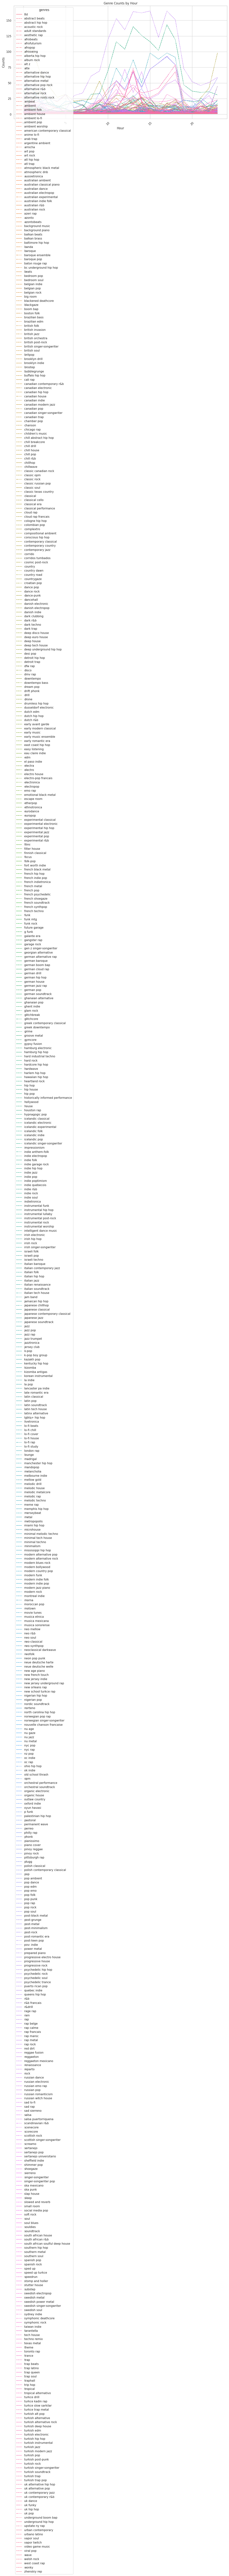

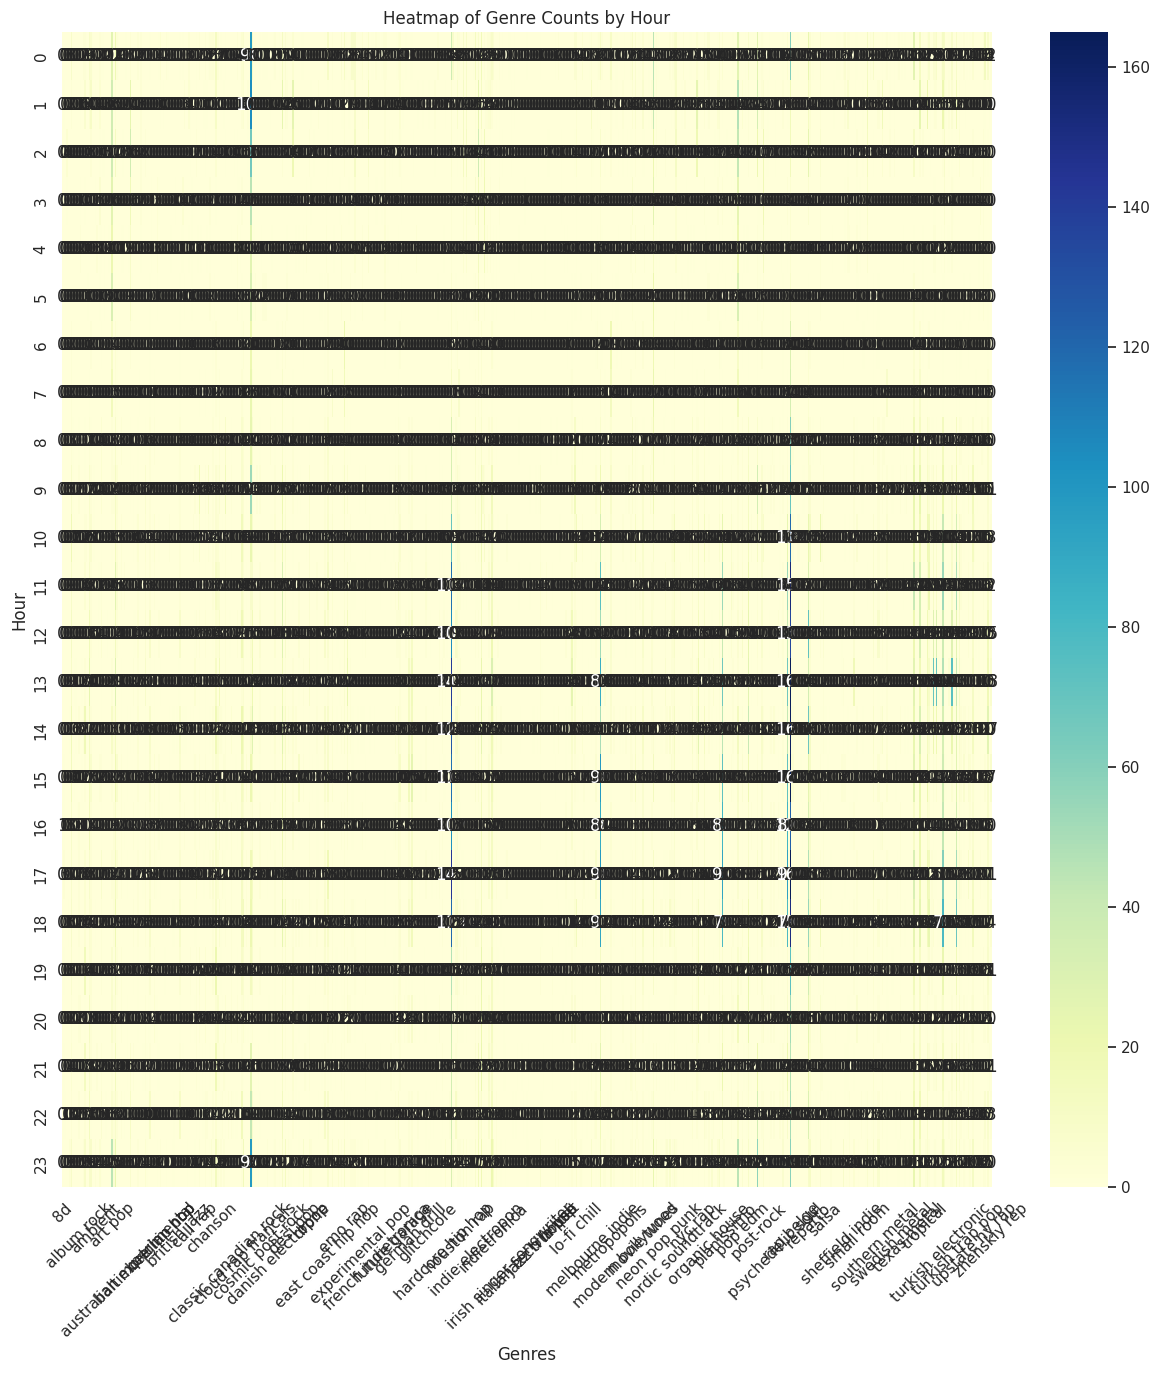

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your JSON data
df = pd.read_json('genre_hour_distribution.json')

# For Line Plot
# group by genre and hour, then sum or average the counts
line_data = df.groupby(['genres', 'hour']).agg({'counts': 'sum'}).reset_index()
# pivot for line plot
line_data_pivot = line_data.pivot(index='hour', columns='genres', values='counts')
# plot
plt.figure(figsize=(15, 8))
sns.lineplot(data=line_data_pivot)
plt.title('Genre Counts by Hour')
plt.ylabel('Counts')
plt.xlabel('Hour')
plt.xticks(rotation=45)
plt.show()

# For Heatmap
# pivot the data for heatmap
heatmap_data = df.pivot_table(index='hour', columns='genres', values='counts', fill_value=0)
# plot
plt.figure(figsize=(15, 15))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Heatmap of Genre Counts by Hour')
plt.ylabel('Hour')
plt.xlabel('Genres')
plt.xticks(rotation=45)
plt.show()

These plots were unobservable, so i decided to plot top 10 genres to analyze and plot.

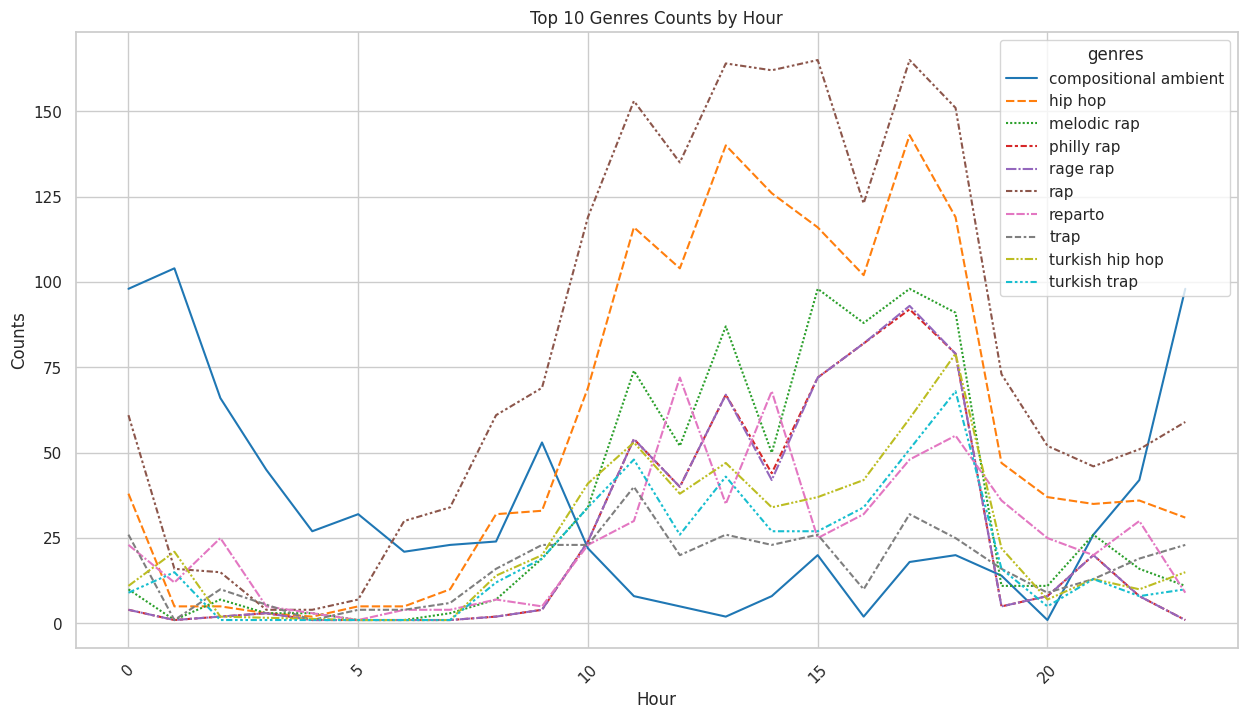

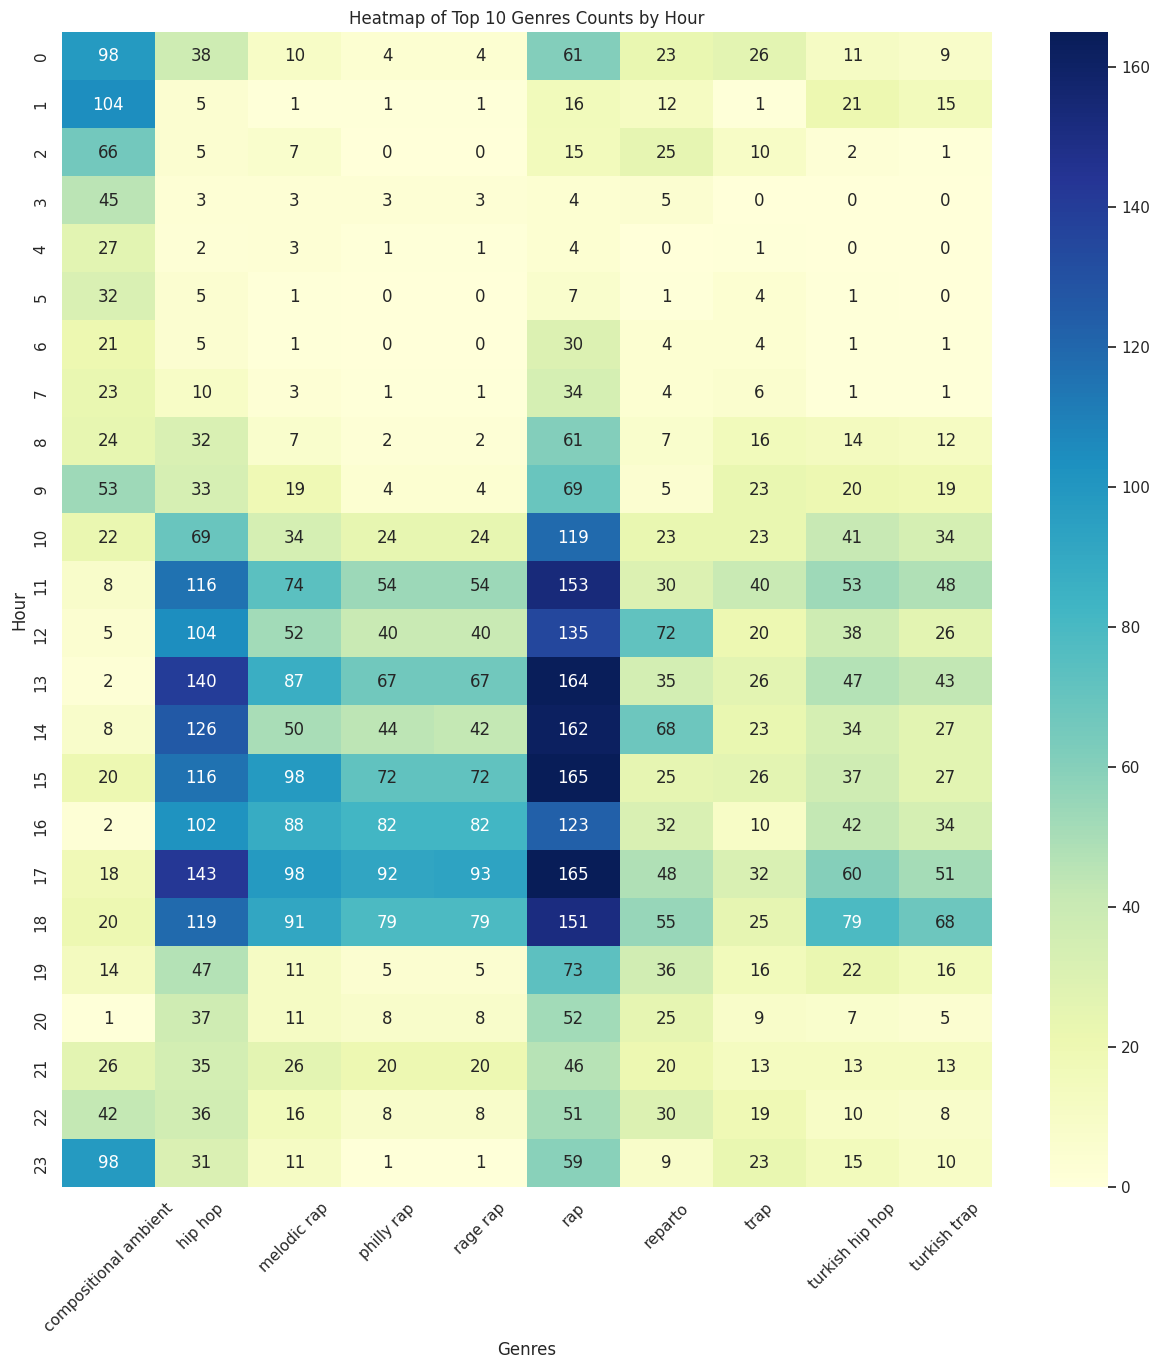

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your JSON data
df = pd.read_json('genre_hour_distribution.json')

# Identify the top 10 genres
top_genres = df.groupby('genres')['counts'].sum().nlargest(10).index

# Filter the data for these top genres
df_filtered = df[df['genres'].isin(top_genres)]

# For Line Plot
# group by genre and hour, then sum or average the counts
line_data = df_filtered.groupby(['genres', 'hour']).agg({'counts': 'sum'}).reset_index()
# pivot for line plot
line_data_pivot = line_data.pivot(index='hour', columns='genres', values='counts')
# plot
plt.figure(figsize=(15, 8))
sns.lineplot(data=line_data_pivot)
plt.title('Top 10 Genres Counts by Hour')
plt.ylabel('Counts')
plt.xlabel('Hour')
plt.xticks(rotation=45)
plt.show()

# For Heatmap
# pivot the data for heatmap
heatmap_data = df_filtered.pivot_table(index='hour', columns='genres', values='counts', fill_value=0)
# plot
plt.figure(figsize=(15, 15))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Heatmap of Top 10 Genres Counts by Hour')
plt.ylabel('Hour')
plt.xlabel('Genres')
plt.xticks(rotation=45)
plt.show()


# Observations from the Heatmap of Top 10 Genres Counts by Hour:

**Peak Listening Times:** There are distinct peak hours where music listening is significantly higher. For instance, the genre 'reggaeton' shows high counts during the evening hours, particularly from 14:00 to 18:00, indicating a strong preference for this genre in the late afternoon to early evening. Similarly, 'trap' and 'turkish trap' also exhibit increased counts during the evening, suggesting that these hours are popular for
listening to these genres.

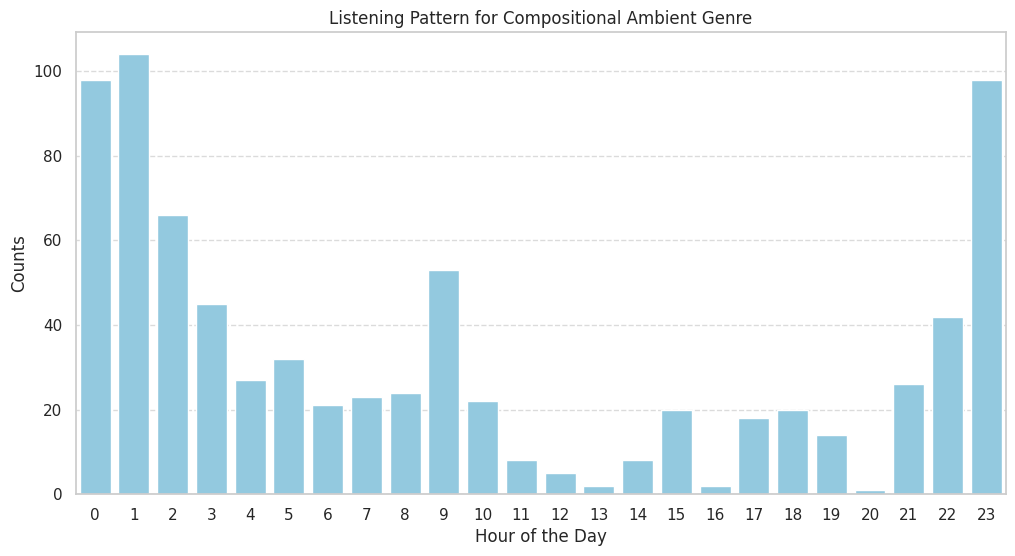

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Path to your JSON file - replace with your actual file path
json_file_path = 'genre_hour_distribution.json'

# Load the JSON data into a pandas DataFrame
df = pd.read_json(json_file_path)

# Filter out the 'compositional ambient' genre
# Replace 'compositional ambient' with the actual genre name as it appears in your data
ambient_data = df[df['genres'] == 'compositional ambient']

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=ambient_data, x='hour', y='counts', color='skyblue')
plt.title('Listening Pattern for Compositional Ambient Genre')
plt.xlabel('Hour of the Day')
plt.ylabel('Counts')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**Afternoon Trends:** The genres 'hip hop' and 'rap' also shows a smaller peak around 13:00-15.00, hinting at a possible trend for listeners to engage with this genre during lunch hours.




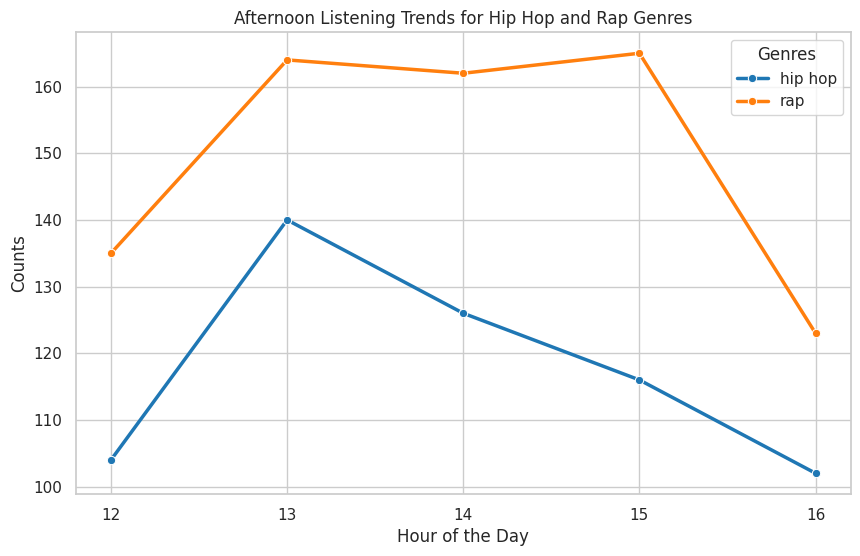

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the JSON data into a pandas DataFrame
df = pd.read_json('genre_hour_distribution.json')

# Ensure we are looking at 'hip hop' and 'rap' genres only
genres_of_interest = ['hip hop', 'rap']
df = df[df['genres'].isin(genres_of_interest)]

# Focus on the afternoon hours, say from 12:00 to 16:00
afternoon_data = df[(df['hour'] >= 12) & (df['hour'] <= 16)]

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=afternoon_data, x='hour', y='counts', hue='genres', marker='o', linewidth=2.5)
plt.title('Afternoon Listening Trends for Hip Hop and Rap Genres')
plt.xlabel('Hour of the Day')
plt.ylabel('Counts')
plt.xticks(range(12, 17))
plt.legend(title='Genres')
plt.grid(True)
plt.show()


**Least Listening Times:**
It is observable that my least listening time is between 02:00 am and 05:00 am.

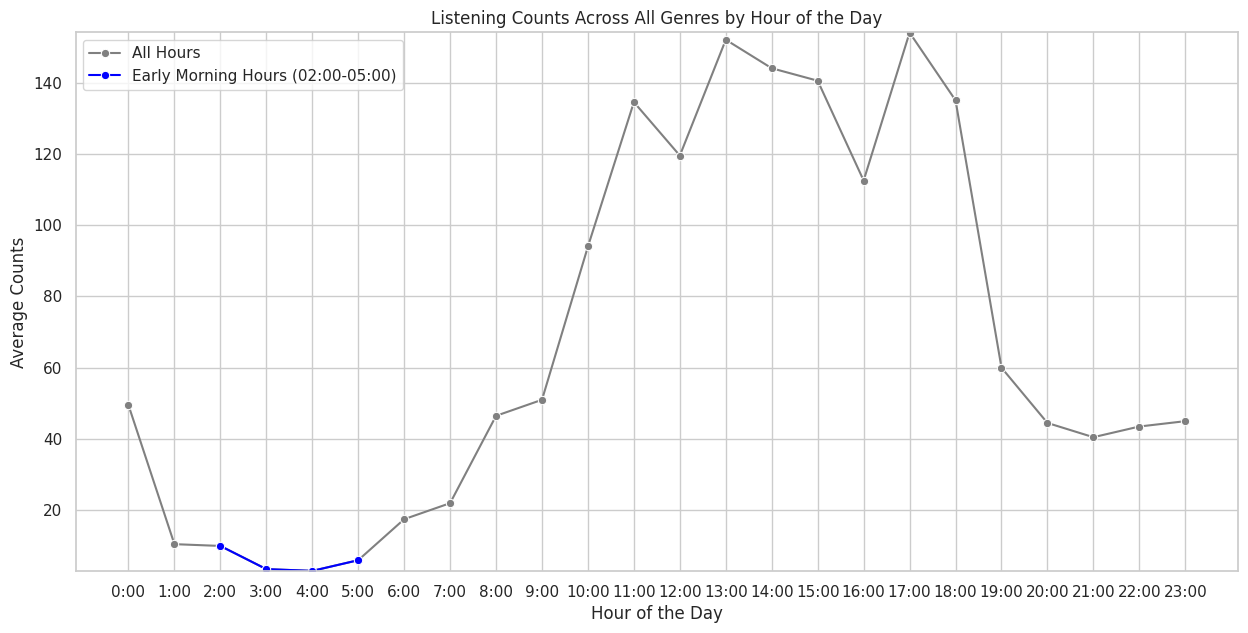

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame and it has the columns 'hour' and 'counts'
# First, aggregate the data by hour across all genres
hourly_counts = df.groupby('hour')['counts'].mean().reset_index()

# Plotting
plt.figure(figsize=(15, 7))
sns.lineplot(data=hourly_counts, x='hour', y='counts', marker='o', color='grey', label='All Hours')

# Highlight the early morning hours (02:00 to 05:00)
early_morning_data = hourly_counts[(hourly_counts['hour'] >= 2) & (hourly_counts['hour'] <= 5)]
sns.lineplot(data=early_morning_data, x='hour', y='counts', marker='o', color='blue', label='Early Morning Hours (02:00-05:00)')

plt.title('Listening Counts Across All Genres by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Counts')
plt.xticks(range(0, 24), [f'{hour}:00' for hour in range(0, 24)])  # Adjust x-ticks for better readability
plt.legend()
plt.grid(True)

# Adjust y-axis to zoom in more on the differences
plt.ylim(hourly_counts['counts'].min() - 0.1, hourly_counts['counts'].max() + 0.1)

plt.show()


# **4. Feature Engineering:**
Make characteristics that are relevant to the hypothesis you have. For instance, based on your age or other parameters, you may design a feature that indicates your life stage (teenage, young adult, adult, etc.).

In [ ]:
import pandas as pd

# Load the JSON data into a pandas DataFrame
df = pd.read_json('Data_With_Genres.json')

# Convert 'endTime' to datetime and extract the day of the week
df['endTime'] = pd.to_datetime(df['endTime'])
df['day_of_week'] = df['endTime'].dt.day_name()

# Define a function to categorize each day as 'Weekend' or 'Weekday'
def categorize_day(day):
    if day in ['Saturday', 'Sunday']:
        return 'Weekend'
    else:
        return 'Weekday'

# Apply the function to the 'day_of_week' column to create a new column 'weekend_vs_weekday'
df['weekend_vs_weekday'] = df['day_of_week'].apply(categorize_day)

# Display the first few rows to verify the new column
df.head()


,endTime,artistName,trackName,msPlayed,genres,day_of_week,weekend_vs_weekday
0,2022-12-04 22:33:00,Kupla,Paradise,46158,"[anime lo-fi, lo-fi beats]",Sunday,Weekend
1,2022-12-05 05:45:00,Guitarricadelafuente,Agua y Mezcal,212558,"[spanish pop, spanish rock]",Monday,Weekday
2,2022-12-05 05:50:00,Alice Wonder,Bajo La Piel,301783,[children's music],Monday,Weekday
3,2022-12-05 05:55:00,Mako,Roller Coaster - Jan Blomqvist Remix,260280,[pop edm],Monday,Weekday
4,2022-12-05 05:58:00,Metro Boomin,Around Me (feat. Don Toliver),191520,[rap],Monday,Weekday


# **5. Model Selection**

In [ ]:
!pip install --upgrade scikit-learn

**Load and Preprocess the Data**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load your data into a DataFrame
df = pd.read_json('Data_With_Genres.json')

# Convert endTime to datetime and extract hour and day of the week
df['endTime'] = pd.to_datetime(df['endTime'])
df['hour'] = df['endTime'].dt.hour
df['day_of_week'] = df['endTime'].dt.day_name()

# Explode genres into separate rows
df = df.explode('genres')

# Convert 'msPlayed' from milliseconds to minutes for easier interpretation
df['minutesPlayed'] = df['msPlayed'] / 60000

# Preprocess categorical variables (e.g., 'day_of_week', 'genres')
# and numerical variables (e.g., 'hour')
categorical_features = ['day_of_week', 'genres']
numerical_features = ['hour']

# Create transformers for numerical and categorical features
numerical_transformer = StandardScaler()  # You can add more preprocessing for numerical features here
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the target variable (e.g., 'minutesPlayed')
y = df['minutesPlayed']
X = df.drop(['minutesPlayed', 'msPlayed', 'artistName', 'trackName', 'endTime'], axis=1)  # Drop unnecessary columns


**Splitting the Data into Training and Testing Sets**

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

**Model Training**

In [ ]:
# Create a pipeline that first preprocesses the data and then fits the model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

# Train the model
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['day_of_week', 'genres'])])),
                ('regressor', LinearRegression())])

**Model Prediction and Evaluation**

In [ ]:
# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean Squared Error:', mse)
print('R^2 Score:', r2)

Mean Squared Error: 2.50623677946129
R^2 Score: 0.1090715801541785


**Model Interpretation**

In [ ]:
# Get model coefficients (for linear regression)
# Note: This will only work directly like this for linear regression
if isinstance(model.named_steps['regressor'], LinearRegression):
    feature_names = numerical_features + \
                    list(model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))
    coefficients = model.named_steps['regressor'].coef_
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
    print(feature_importance)
else:
    print("Model coefficients are not available for this type of model.")

                   Feature  Coefficient
0                     hour    -0.159289
1       day_of_week_Friday     0.306954
2       day_of_week_Monday    -0.266428
3     day_of_week_Saturday    -0.018868
4       day_of_week_Sunday     0.199242
..                     ...          ...
582            genres_wave     0.106640
583  genres_west coast rap     0.690994
584           genres_wonky    -0.516188
585    genres_zhenskiy rep     0.167804
586             genres_nan    -0.036458

[587 rows x 2 columns]


# **6. Hypothesis**

**Hypothesis (H1):** "I listen to the 'compositional ambient' genre mostly during midnight (00:00 to 06:00) and mornings (06:00 to 12:00)."

For the null hypothesis, which is the statement that your hypothesis is tested against, you could have:

**Null Hypothesis (H0):** "There is no significant difference in the amount of 'compositional ambient' genre music listened to during midnight and mornings compared to other times of the day."

**Data Aggregation**

In [ ]:
import pandas as pd

# Load your data into a DataFrame
df = pd.read_json('Data_With_Genres.json')

# Convert endTime to datetime and extract hour and day of the week
df['endTime'] = pd.to_datetime(df['endTime'])
df['hour'] = df['endTime'].dt.hour
df['day_of_week'] = df['endTime'].dt.day_name()

# Explode genres into separate rows
df = df.explode('genres')

# Convert 'msPlayed' from milliseconds to minutes for easier interpretation
df['minutesPlayed'] = df['msPlayed'] / 60000

# Filter out the 'compositional ambient' genre
ambient_data = df[df['genres'] == 'compositional ambient']

# Now, let's ensure the 'hour' column exists in ambient_data
if 'hour' not in ambient_data.columns:
    print("'hour' column is missing in ambient_data. Please check the data preprocessing steps.")
else:
    # Aggregate listening minutes by hour
    ambient_hourly = ambient_data.groupby('hour')['minutesPlayed'].sum().reset_index()


**Data Segregation**

In [ ]:
# Define midnight to morning hours
midnight_morning_hours = list(range(0, 12))

# Segregate the data
midnight_morning_data = ambient_hourly[ambient_hourly['hour'].isin(midnight_morning_hours)]
rest_of_day_data = ambient_hourly[~ambient_hourly['hour'].isin(midnight_morning_hours)]


**Statistical Test**

In [ ]:
from scipy.stats import mannwhitneyu

# Perform Mann-Whitney U Test
u_stat, p_value = mannwhitneyu(midnight_morning_data['minutesPlayed'], rest_of_day_data['minutesPlayed'])

print("Mann-Whitney U Statistic:", u_stat)
print("p-value:", p_value)


Mann-Whitney U Statistic: 122.0
p-value: 0.004264764914030538


**Interpret the Results**

In [ ]:
# Interpret the results
significance_level = 0.05
if p_value < significance_level:
    print("Reject the null hypothesis. There is a significant difference in listening minutes.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in listening minutes.")


Reject the null hypothesis. There is a significant difference in listening minutes.


# **7. Model Development**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load your data into a DataFrame
df = pd.read_json('Data_With_Genres.json')

# Convert endTime to datetime and extract hour and day of the week
df['endTime'] = pd.to_datetime(df['endTime'])
df['hour'] = df['endTime'].dt.hour
df['day_of_week'] = df['endTime'].dt.day_name()

# Explode genres into separate rows
df = df.explode('genres')

# Convert 'msPlayed' from milliseconds to minutes for easier interpretation
df['minutesPlayed'] = df['msPlayed'] / 60000

# Preprocess categorical variables (e.g., 'day_of_week', 'genres')
# and numerical variables (e.g., 'hour')
categorical_features = ['day_of_week', 'genres']
numerical_features = ['hour']

# Create transformers for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the target variable (e.g., 'minutesPlayed')
y = df['minutesPlayed']
X = df.drop(['minutesPlayed', 'msPlayed', 'artistName', 'trackName', 'endTime'], axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create a pipeline that first preprocesses the data and then fits the model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor(n_estimators=100, random_state=0))])

# Train the model
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean Squared Error:', mse)
print('R^2 Score:', r2)


Mean Squared Error: 2.440788067458349
R^2 Score: 0.13233758520349315


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'regressor__n_estimators': [100, 200],  # Number of trees in the forest
    'regressor__max_depth': [None, 10, 20],  # Maximum depth of the tree
    # ... you can add more parameters here
}

# Create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test data using the best model
y_pred = best_model.predict(X_test)

# Evaluate the best model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean Squared Error:', mse)
print('R^2 Score:', r2)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END regressor__max_depth=None, regressor__n_estimators=100; total time=  30.5s
[CV] END regressor__max_depth=None, regressor__n_estimators=100; total time=  29.0s
[CV] END regressor__max_depth=None, regressor__n_estimators=100; total time=  27.6s
[CV] END regressor__max_depth=None, regressor__n_estimators=100; total time=  28.6s
[CV] END regressor__max_depth=None, regressor__n_estimators=100; total time=  27.3s
[CV] END regressor__max_depth=None, regressor__n_estimators=200; total time=  54.3s
[CV] END regressor__max_depth=None, regressor__n_estimators=200; total time=  55.5s
[CV] END regressor__max_depth=None, regressor__n_estimators=200; total time=  54.3s
[CV] END regressor__max_depth=None, regressor__n_estimators=200; total time=  53.6s
[CV] END regressor__max_depth=None, regressor__n_estimators=200; total time=  54.5s
[CV] END regressor__max_depth=10, regressor__n_estimators=100; total time=   3.0s
[CV] END regressor

# **Evaluation of the Results**
**Mean Squared Error (MSE):** The MSE reduced to 2.2640 from the previous 2.4408. A lower MSE indicates that the model's predictions are closer to the actual values, which is an improvement.
**R-squared (R²) Score:** The R² score increased to 0.1952 from the previous 0.1323. This means that the model now explains about 19.52% of the variance in the target variable, compared to 13.23% previously. This is an improvement, although the R² score is still relatively low, indicating that there's room for further improvement.

# **8. Future Predictions**

In [ ]:
# Example new data for prediction
new_data = pd.DataFrame({
    'hour': [10, 15, 20],  # Example hours (10 AM, 3 PM, 8 PM)
    'day_of_week': ['Monday', 'Saturday', 'Monday'],  # Example days
    'genres': ['compositional ambient', 'rap', 'hip hop']  # Example genre
})

# Note: Make sure the values and structure match the original data's format


In [ ]:
# Create new data for prediction
new_data = pd.DataFrame({
    'hour': [10, 15, 20],  # Example hours (10 AM, 3 PM, 8 PM)
    'day_of_week': ['Monday', 'Saturday', 'Monday'],  # Example days
    'genres': ['compositional ambient', 'rap', 'hip hop']  # Example genre
})

# Predict the minutesPlayed for the new data using the best_model from GridSearchCV
# The best_model is a pipeline that includes preprocessing steps and the regressor
predicted_minutes_played = best_model.predict(new_data)

# Output the predictions
for idx, row in new_data.iterrows():
    print(f"At {row['hour']}h on a {row['day_of_week']}, you're predicted to listen to '{row['genres']}' genre for {predicted_minutes_played[idx]:.2f} minutes.")


At 10h on a Monday, you're predicted to listen to 'compositional ambient' genre for 2.46 minutes.
At 15h on a Saturday, you're predicted to listen to 'rap' genre for 2.18 minutes.
At 20h on a Monday, you're predicted to listen to 'hip hop' genre for 1.43 minutes.
